## Hausarbeit 6
• Verwenden Sie die MSELoss Function und vergleichen das Resultat mit der NLLLoss Function.

• Versuchen Sie durch verkleinern des Netzwerkes das Übertraining zu verringern.


<span style="color:red">**Anmerkung: Die Beantwortung der Fragen finden Sie im Verlauf des Notebooks**</span>

In [154]:
# Laden der notwendigen Bibliotheken
from torchvision import datasets
from torchvision import transforms
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [155]:
# Laden des Datensatzes CIFAR-10 
# Der Datensatz umfasst viele kleine Bilder mit Label
cifar10 = datasets.CIFAR10('data', train=True, download=True)
cifar10_val = datasets.CIFAR10('data', train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


#### Erkunden des Datensatzes

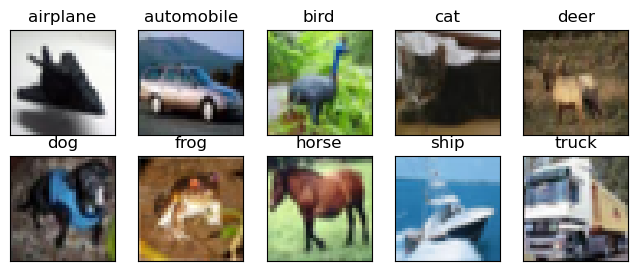

In [156]:
# Definition der Klassennamen im Datensatz
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

# Darstellung einzelner Beispiele der Klassen im Subplot
fig = plt.figure(figsize=(8,3))
num_classes = 10
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    img = next(img for img, label in cifar10 if label == i)
    plt.imshow(img)
plt.show()

#### Transformation der Daten in einen Pytorch Tensor und Normalisierung der Daten

In [157]:
# Alle Tensoren in einer Variablen gespeichert.
cifar10 = datasets.CIFAR10('data', train=True, download=False,
                          transform=transforms.ToTensor())
img, _ = cifar10[99]
imgs = torch.stack([img for img, _ in cifar10], dim=3)

# Recall that view(3, -1) merges all the remaining dimensions into one, 
# figuring out the appropriate size. Here our 3 × 32 × 32 image is 
# transformed into a 3 × 1,024 vector, and then the mean 
# is taken over the 1,024 elements of each channel.

# Berechnung des Mittelwerts
mittelwert = imgs.view(3, -1).mean(dim=1)
# Berechnung der Standardabweichung
standardabweichung = imgs.view(3, -1).std(dim=1)

print('Der Mittelwert ist:', mittelwert)
print('Die Standardabweichung ist:', standardabweichung)

Der Mittelwert ist: tensor([0.4914, 0.4822, 0.4465])
Die Standardabweichung ist: tensor([0.2470, 0.2435, 0.2616])


In [158]:
# Durchführung der Normalisierung
transforms.Normalize(mittelwert, standardabweichung)

# Datensatz normalisiert (Trainingsdaten)
cifar10 = datasets.CIFAR10(
    'data', train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((mittelwert),
                             (standardabweichung))
                             ]))

# Datensatz normalisiert (Validierungsdaten)
cifar10_val = datasets.CIFAR10('data', train=False, download=False,
                          transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize((mittelwert),
                                                   (standardabweichung))
                          ]))

#### Entwicklung eins "Fully connected model"

In [159]:
# Erstellung des Datensatzes
label_map = {0: 0, 2: 1}
cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]

#### 1. Aufgabe: Vergleich der MSELoss-Function mit der NLLLoss-Function
**MSELoss-Function: Mean Squared Error Loss Function** = berechnet den Durchschnitt der quadratischen Differenzen zwischen den tatsächlichen und den vorhergesagten Werten.

**NLLLoss-Function: Negative Log-Likelihood Loss Function** = berechnet den negativen Logarithmus der Wahrscheinlichkeit der korrekten Klasse. 

#### 1. Schritt: Trainieren zweier Modelle einmal mit der MSELoss-Funktion und mit der NLLLoss-Funktion:

In [160]:
# Listen zum Speichern der Werte der jeweiligen Loss-Funktion
NLL_loss_value = []
MSE_loss_value = []
epoche = []

# Definition des Training-Loops
def training_loop(model, learning_rate, loss_fn, train_loader, n_epochs):
    model_fn_1, model_fn_2 = model
    loss_fn_1, loss_fn_2 = loss_fn

    optimizer_fn_1 = optim.SGD(model_fn_1.parameters(), lr=learning_rate)
    optimizer_fn_2 = optim.SGD(model_fn_2.parameters(), lr=learning_rate)
    
    for epoch in range(n_epochs):
        for imgs, labels in train_loader:
            
            outputs_fn_1 = model_fn_1(imgs.view(imgs.shape[0], -1))
            outputs_fn_2 = model_fn_2(imgs.view(imgs.shape[0], -1))

            #### NLLLoss-Function ####
            # Labels müssen nicht umkodiert werden, da die NLLLoss-Function die Kodierung übernimmt. 
            loss_1 = loss_fn_1(outputs_fn_1, labels)

            optimizer_fn_1.zero_grad()
            loss_1.backward()
            optimizer_fn_1.step()
            
            #### MSELoss-Function ####
            # Für die MSE-Loss-Funktion müssen die Labels des Targets umkodiert werden. 
            onehot_labels = torch.nn.functional.one_hot(labels, 2)
            loss_2 = loss_fn_2(outputs_fn_2, onehot_labels.float())
    
            optimizer_fn_2.zero_grad()
            loss_2.backward()
            optimizer_fn_2.step()

            # Anhängen der Werte zum plotten
            epoche.append(epoch)
            NLL_loss_value.append(loss_1.detach().numpy())
            MSE_loss_value.append(loss_2.detach().numpy())
        print("Epoch: %d, NLLLoss: %f, MSELoss: %f" % (epoch, float(loss_1), float(loss_2)))


# Dataloader (ermöglicht ein schnelleres Trainieren)
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

# Definition der Modelle
NLL_model = nn.Sequential(
    nn.Linear(3072, 128),
    nn.Tanh(),
    nn.Linear(128, 2),
    nn.LogSoftmax(dim=1))

MSE_model = nn.Sequential(
    nn.Linear(3072, 128),
    nn.Tanh(),
    nn.Linear(128, 2),
    nn.LogSoftmax(dim=1))

model = [NLL_model, MSE_model]

# Definition der Lernrate
learning_rate = 1e-2

# Definition der Loss-Funktionen
MSE_loss_fn = nn.MSELoss()
NLL_loss_fn = nn.NLLLoss()
loss_fn = [NLL_loss_fn, MSE_loss_fn]

# Anzahl der Trainingsepochen
n_epochs = 100

# Übergabe der Werte in den Trainingsloop
training_loop(model, learning_rate, loss_fn, train_loader, n_epochs)

Epoch: 0, NLLLoss: 0.379176, MSELoss: 1.614345
Epoch: 1, NLLLoss: 0.541868, MSELoss: 1.640533
Epoch: 2, NLLLoss: 0.416459, MSELoss: 1.614979
Epoch: 3, NLLLoss: 0.483224, MSELoss: 1.631687
Epoch: 4, NLLLoss: 0.599734, MSELoss: 1.654255
Epoch: 5, NLLLoss: 0.257686, MSELoss: 1.601377
Epoch: 6, NLLLoss: 0.384521, MSELoss: 1.623013
Epoch: 7, NLLLoss: 0.436213, MSELoss: 1.615293
Epoch: 8, NLLLoss: 0.293940, MSELoss: 1.598192
Epoch: 9, NLLLoss: 0.365523, MSELoss: 1.614372
Epoch: 10, NLLLoss: 0.349217, MSELoss: 1.613488
Epoch: 11, NLLLoss: 0.250661, MSELoss: 1.591591
Epoch: 12, NLLLoss: 0.434875, MSELoss: 1.625903
Epoch: 13, NLLLoss: 0.167766, MSELoss: 1.598087
Epoch: 14, NLLLoss: 0.440607, MSELoss: 1.635984
Epoch: 15, NLLLoss: 0.104976, MSELoss: 1.582572
Epoch: 16, NLLLoss: 0.385255, MSELoss: 1.637457
Epoch: 17, NLLLoss: 0.398951, MSELoss: 1.622402
Epoch: 18, NLLLoss: 0.207790, MSELoss: 1.595392
Epoch: 19, NLLLoss: 0.489390, MSELoss: 1.630605
Epoch: 20, NLLLoss: 0.155970, MSELoss: 1.586276
Ep

#### 2. Schritt: Vergleich der Genauiskeit beider Modelle in Abhängigkeit des Trainings- und des Validierungsdatensatzes:

In [161]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

#### NLLLoss-Function ####
# Trainingsdatensatz
correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in train_loader:
        outputs_fn_1 = NLL_model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs_fn_1, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy (Traindata) NLLLoss-Function: %f" % (correct / total))

correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in val_loader:
        outputs_fn_1 = NLL_model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs_fn_1, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy (Valdata) NLLLoss-Function: %f" % (correct / total))

#### MSELoss-Function
# Trainingsdatensatz
correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in train_loader:
        outputs_fn_2 = MSE_model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs_fn_2, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy (Traindata) MSELoss-Function: %f" % (correct / total))

# Validierungsdatensatz
correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in val_loader:
        outputs_fn_2 = MSE_model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs_fn_2, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy (Valdata) MSELoss-Function: %f" % (correct / total))

Accuracy (Traindata) NLLLoss-Function: 0.999400
Accuracy (Valdata) NLLLoss-Function: 0.809000
Accuracy (Traindata) MSELoss-Function: 0.981600
Accuracy (Valdata) MSELoss-Function: 0.781500


#### 3. Schritt: Vergleich der Loss-Values im Verlauf der Epochen in einem Plot:

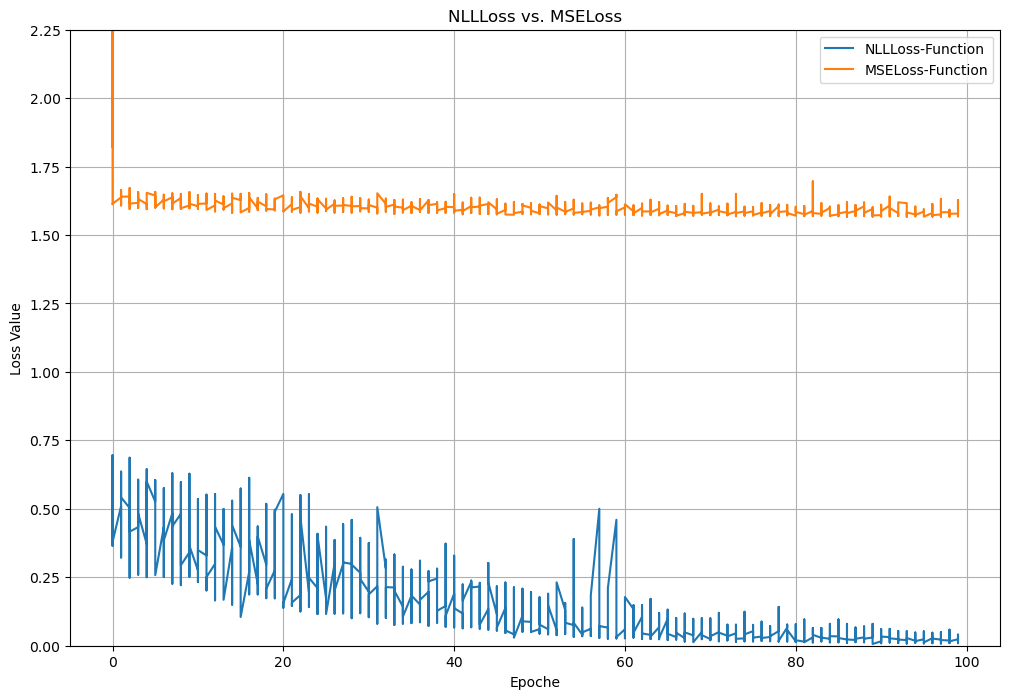

In [162]:
# Print Loss-Values vs. Epoche
plt.figure(figsize=(12, 8))
plt.plot(epoche, NLL_loss_value, label="NLLLoss-Function")
plt.plot(epoche, MSE_loss_value, label="MSELoss-Function")
plt.xlabel("Epoche")
plt.ylabel("Loss Value")
plt.title("NLLLoss vs. MSELoss")
plt.legend()
plt.ylim(0, 2.25)
plt.grid()
plt.show()


#### Antwort: 
Der Vergleich der beiden Loss-Funktionen zeigt, dass die NLLLoss-Funktion ein deutlich besseres Trainingsverhalten aufzeigt als die MSELoss-Funktion. Insbesondere in der Abbildung ist zu erkennen, dass der Loss-Value für die MSE-Loss-Funktion über die Anzahl der Epochen konstant bei ungefähr 1,6 liegt und weder fällt noch steigt. Der Loss-Value für die NLLLoss-Funktion fällt jedoch dagegen kontinuierlich mit der Anzahl der Epochen und nähert sich der Null an. Dieses Verhalten ist darin begründet, dass die MSELoss-Funktion grundsätzlich eher für Regressionsprobleme als für Klassifizierungsprobleme geeignet ist. Für Probleme mit mehreren Klassen ist die NLLLoss-Funktion deutlich besser geeignet.  

#### 2.Aufgabe: Verkleinerung des Netzwerks zur Reduktion des Übertrainings

In [163]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

num_hidden_layer = 3

model = nn.Sequential(
            nn.Linear(3072, num_hidden_layer),
            nn.Tanh(),
            nn.Linear(num_hidden_layer, 2),
            nn.LogSoftmax(dim=1))

learning_rate = 1e-3

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

    

Epoch: 0, Loss: 0.685766
Epoch: 1, Loss: 0.421416
Epoch: 2, Loss: 0.523831
Epoch: 3, Loss: 0.375219
Epoch: 4, Loss: 0.417069
Epoch: 5, Loss: 0.531483
Epoch: 6, Loss: 0.573731
Epoch: 7, Loss: 0.559996
Epoch: 8, Loss: 0.419349
Epoch: 9, Loss: 0.551968
Epoch: 10, Loss: 0.464554
Epoch: 11, Loss: 0.406614
Epoch: 12, Loss: 0.529070
Epoch: 13, Loss: 0.469934
Epoch: 14, Loss: 0.543731
Epoch: 15, Loss: 0.631291
Epoch: 16, Loss: 0.428952
Epoch: 17, Loss: 0.378003
Epoch: 18, Loss: 0.437676
Epoch: 19, Loss: 0.428477
Epoch: 20, Loss: 0.357685
Epoch: 21, Loss: 0.536824
Epoch: 22, Loss: 0.617753
Epoch: 23, Loss: 0.508670
Epoch: 24, Loss: 0.338273
Epoch: 25, Loss: 0.336633
Epoch: 26, Loss: 0.358715
Epoch: 27, Loss: 0.424340
Epoch: 28, Loss: 0.300542
Epoch: 29, Loss: 0.417888
Epoch: 30, Loss: 0.374304
Epoch: 31, Loss: 0.400903
Epoch: 32, Loss: 0.368305
Epoch: 33, Loss: 0.401060
Epoch: 34, Loss: 0.492875
Epoch: 35, Loss: 0.372466
Epoch: 36, Loss: 0.455488
Epoch: 37, Loss: 0.306416
Epoch: 38, Loss: 0.628

In [164]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

# Trainingsdatensatz
correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in train_loader:
        outputs_fn_1 = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs_fn_1, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy (Traindata): %f" % (correct / total))

correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in val_loader:
        outputs_fn_1 = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs_fn_1, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy (Valdata): %f" % (correct / total))

Accuracy (Traindata): 0.830900
Accuracy (Valdata): 0.805000


#### Antwort:

Das in der ersten Aufgabe verwendete Modell

model = nn.Sequential( <br>
    nn.Linear(3072, 128), <br>
    nn.Tanh(),<br>
    nn.Linear(128, 2),<br>
    nn.LogSoftmax(dim=1))<br>

wurde mit einer Lernrate von lr = 1e-2 trainiert. 

Hierbei erreicht das Modell folgende Werte für die Genauigkeit: <br>
Accuracy (Traindata): 0.999400 <br>
Accuracy (Valdata): 0.817500

Es ist deutlich zu erkennen, dass das Modell übertrainiert ist, da es die Trainigsdaten fast zu 100 % richtig kategorisiert und bei den Validierungsdaten lediglich 81,75 % der Daten korrekt kategorisiert.

Um die Diskrepanz zwischen der Genauigkeit des Modells für die beiden Datensätze anzugleichen, sodass das Netz nicht mehr übertrainiert ist, wurde für das neue Modell zum einen die Lernrate auf 1e-3 reduziert und zum anderen die Anzahl der versteckten Neuronen und Trainingsepochen verringert.   

| Anzahl Layer | Lernrate | Anzahl Epochen | Genauigkeit Trainingsdaten | Genauigkeit Validierungsdaten | Diskrepanz |
|----------|----------|----------|----------|----------|----------|
| 128  | 1e-2   | 100   | 0.99400   | 0.8175   | 0.1765 |
| 10  | 1e-2   | 100   | 0.9595   | 0.79200   | 0.1675 |
| 3  | 1e-2   | 100   | 0.90180   | 0.79500   | 0.1068 |
| 3  | 1e-3   | 100   | 0.8402   | 0.8095   | 0.0307 |
| 3  | 1e-3   | 75   | 0.8299   | 0.8065   | 0.0234 |
| 3  | 1e-3   | 50   | 0.8213   | 0.8020  | 0.0193 |

Die Tabelle zeigt auf, dass bereits die Verringerung der Anzahl der versteckten Neuronen die Diskrepanz zwischen der Genauigkeit des Modells auf die Validierungsdaten und der Trainingsdaten reduziert. Insbesondere die Anpassung der Lernrate auf 1e-3 bei reduzierter Neuronen-Anzahl und gleichbleibender Anzahl an Trainingsepochen verbessert die Diskrepanz und sorgt dafür, dass das Model weniger übertrainiert ist. Mit der Reduzierung der Trainingsepochen kann das Übertraining weiter reduziert werden. 
Es ist also erkenntlich, dass nicht nur das Verkleinern des Netzwerks das Übertraining verringert, sondern insbesondere die Parameter Lernrate und Anzahl der Trainingsepochen einen Einfluss darauf haben. 
Jedoch sollte beim Trainieren des Modells die Parameter spezifisch ausgewählt werden, sodass das Modell weiterhin einen guten Trainingserfolg erzielt, ohne dass dabei die Gefahr einzugehen, dass das Modell übertrainiert (overfitted) wird.
